# Analisis Interaksi FED Rate, BI Rate, dan Inflasi Indonesia 2017–2024 dalam Perspektif Kebijakan Moneter


---


Tujuan proyek ini adalah mengembangkan sistem analisis hubungan antara FED Rate, BI Rate, dan inflasi Indonesia periode 2017–2024 untuk mendukung rekomendasi kebijakan moneter dan fiskal. Latar belakang penelitian didasari
oleh kebutuhan Bank Indonesia dan Pemerintah dalam merespons dinamika global serta menjaga stabilitas harga domestik. Permasalahan yang diangkat bersifat spesifik dan relevan, yaitu bagaimana pergerakan suku bunga global memengaruhi kebijakan suku bunga domestik dan inflasi nasional. Pendekatan dilakukan secara runtut melalui pengumpulan data historis, analisis statistik, visualisasi tren, hingga pemanfaatan LLM untuk menghasilkan insight dan rekomendasi kebijakan yang berbasis data.


In [ ]:
# LangChain + Replicate (LLM)
!pip install langchain_community
!pip install replicate

# Data wrangling & analisis
!pip install pandas
!pip install numpy
!pip install statsmodels

# Visualisasi
!pip install matplotlib
!pip install seaborn

# Excel support
!pip install openpyxl
!pip install xlrd


In [ ]:
# Import Libraries
from langchain_community.llms import Replicate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from google.colab import files

In [ ]:
from google.colab import userdata

# Set the API token
api_token = userdata.get('REPLICATE_API_TOKEN')
os.environ["REPLICATE_API_TOKEN"] = api_token

parameters = {
  "top_k": 5,
  "top_p": 1.0,
  "max_tokens": 4096,
  "min_tokens": 0,
  "random_seed": None,
  "temperature": 0,
  "repetition_penalty": 1.0,
  "stopping_criteria": "length (256 tokens)",
  "stopping_sequence": None
}

llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs=parameters
)

## Data Preparations & Data Analysis


In [ ]:
import pandas as pd

fed_file_path = '/content/dataset/fed_rate.xlsx'
fed_sheet = pd.ExcelFile(fed_file_path)
print("Fed Rate sheets:", fed_sheet.sheet_names)


Fed Rate sheets: ['README', 'Monthly']


In [ ]:
# Assuming the data is in sheet named 'Monthly' and header is in row 2 (index 1)
fed_data = pd.read_excel(fed_file_path, sheet_name='Monthly', header=0)

# Preview Fed Rate data
print(fed_data.head())


  observation_date  FEDFUNDS
0       2017-01-01      0.65
1       2017-02-01      0.66
2       2017-03-01      0.79
3       2017-04-01      0.90
4       2017-05-01      0.91


In [ ]:
# Preview data
print("fed columns:", fed_data.columns)

fed columns: Index(['observation_date', 'FEDFUNDS'], dtype='object')


In [ ]:
# Load BI Rate
bi_file_path = '/content/dataset/bi_7day_rr.xlsx'
bi_data = pd.read_excel(bi_file_path, header=4)

# Load Inflation
inflation_file_path = '/content/dataset/inflation.xlsx'
inflation_data = pd.read_excel(inflation_file_path, header=4)

# Clean column names
for df in [bi_data, inflation_data]:
    df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()

# Preview cleaned data
print("BI Rate columns:", bi_data.columns)
print("Inflation columns:", inflation_data.columns)

BI Rate columns: Index(['no', 'tanggal', 'bi-7day-rr', 'unnamed:_3'], dtype='object')
Inflation columns: Index(['no', 'periode', 'data_inflasi', 'unnamed:_3'], dtype='object')


In [ ]:
import pandas as pd

# Fed Rate → annual
fed_data['year'] = pd.to_datetime(fed_data['observation_date'], errors='coerce').dt.year
fed_data_annual = fed_data.groupby('year')['FEDFUNDS'].mean().reset_index()

# BI Rate → annual
bi_data['tanggal'] = bi_data['tanggal'].str.replace(r',.*', '', regex=True)
bulan_map = {
    'Januari': '01', 'Februari': '02', 'Maret': '03', 'April': '04',
    'Mei': '05', 'Juni': '06', 'Juli': '07', 'Agustus': '08',
    'September': '09', 'Oktober': '10', 'November': '11', 'Desember': '12'
}
for b, n in bulan_map.items():
    bi_data['tanggal'] = bi_data['tanggal'].str.replace(b, n)

bi_data['year'] = pd.to_datetime(bi_data['tanggal'], dayfirst=True, errors='coerce').dt.year

# Make sure the BI Rate column is a string first
bi_data['bi-7day-rr'] = bi_data['bi-7day-rr'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)

bi_data_annual = bi_data.groupby('year')['bi-7day-rr'].mean().reset_index()

# Inflation → annual
inflation_data['periode'] = inflation_data['periode'].astype(str)
inflation_data['year'] = pd.to_datetime(inflation_data['periode'], errors='coerce').dt.year
inflation_data['data_inflasi'] = inflation_data['data_inflasi'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)

inflation_data_annual = inflation_data.groupby('year')['data_inflasi'].mean().reset_index()

# Merge all annual data
annual_data = fed_data_annual.merge(bi_data_annual, on='year')
annual_data = annual_data.merge(inflation_data_annual, on='year')

print(annual_data)



   year  FEDFUNDS  bi-7day-rr  data_inflasi
0  2017  1.001667    4.562500      3.730000
1  2018  1.831667    5.057692      3.173333
2  2019  2.158333    5.625000      3.073333
3  2020  0.375833    4.250000      1.893333
4  2021  0.080000    3.520833      1.590000
5  2022  1.683333    4.000000      4.946667
6  2023  5.024167    5.812500      3.156667
7  2024  5.143333    6.104167      2.130000


/tmp/ipython-input-2824634301.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  inflation_data['year'] = pd.to_datetime(inflation_data['periode'], errors='coerce').dt.year


## Insight & Findings

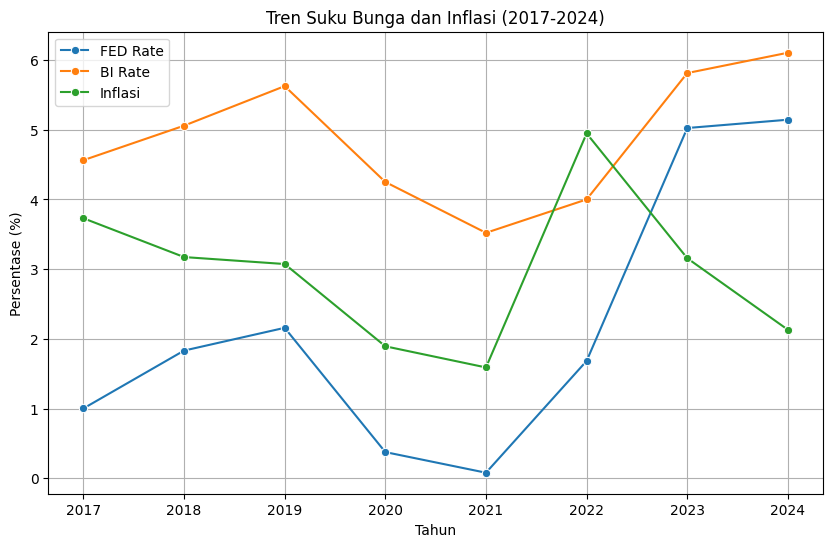

**Analisis Tren**

Tren FED Rate dari 2017 hingga 2024 menunjukkan pola naik-turun. Dari tahun 2017 hingga 2019, FED Rate naik bertahap, sebagai respon terhadap pertumbuhan ekonomi yang kuat dan inflasi yang masih di atas target. Tetapi, tahun 2020 dan awal 2021 melihat FED Rate jatuh drastis, sebagai respon terhadap pandemie COVID-19 yang menyebabkan kekurangan ekonomi global. Setelah itu, FED Rate melonjak tajam pada tahun 2022 dan terus meningkat hingga 2024, sebagai respon terhadap inflasi yang meningkat.

BI Rate, seperti FED Rate, juga menunjukkan pola yang sama, tetapi dengan ketidak stabilan yang lebih besar. BI Rate lebih stabil dari FED Rate pada awal periode, tetapi mengikuti arah FED dengan penurunan pada tahun 2020-2021. Namun, BI Rate kemudian menunjukkan kenaikan signifikan pada tahun 2022 hingga 2024, sebagai respon terhadap inflasi yang meningkat di Indonesia.

Inflasi Indonesia turun dari 3,73% pada 2017 hingga 1,59% pada 2021, sebagai indikator ekonomi yang stabil. N

In [ ]:
# Take the annual_data data that has been created
import matplotlib.pyplot as plt
import seaborn as sns

# Line chart: FED & BI Rate + Inflasi
plt.figure(figsize=(10,6))
sns.lineplot(data=annual_data, x='year', y='FEDFUNDS', marker='o', label='FED Rate')
sns.lineplot(data=annual_data, x='year', y='bi-7day-rr', marker='o', label='BI Rate')
sns.lineplot(data=annual_data, x='year', y='data_inflasi', marker='o', label='Inflasi')

plt.title("Tren Suku Bunga dan Inflasi (2017-2024)")
plt.xlabel("Tahun")
plt.ylabel("Persentase (%)")
plt.legend()
plt.grid(True)
plt.show()

prompt_analysis = f"""
Anda adalah seorang ekonom profesional.
Tuliskan analisis lengkap dalam **bahasa Indonesia** mengenai tren tahunan
FED Rate, BI 7-Day Reverse Repo Rate, dan Inflasi Indonesia periode 2017–2024.
Jangan gunakan bahasa Inggris sama sekali, kecuali istilah resmi seperti "FED Rate" atau "BI Rate".

Data yang digunakan:
{annual_data.to_dict(orient='records')}

Gambaran grafik (2017–2024):
- FED Rate naik bertahap 2017–2019, jatuh drastis 2020–2021, lalu melonjak tajam 2022–2023 hingga bertahan tinggi di 2024.
- BI Rate lebih stabil, tetapi mengikuti arah FED dengan pola penurunan 2020–2021 lalu kenaikan signifikan 2022–2024.
- Inflasi cenderung turun 2017–2021, melonjak di 2022, lalu kembali turun di 2023–2024.

=== Instruksi Wajib Penulisan ===
1. Analisis HARUS dibagi ke dalam 4 subjudul:
   - Analisis Tren
   - Analisis Hubungan & Korelasi
   - Dampak Ekonomi
   - Ringkasan Insight
2. Semua bagian ditulis dalam bahasa Indonesia yang profesional, jelas, dan mudah dipahami.
3. Setiap subjudul maksimal 2–3 paragraf.
4. Gunakan bullet point untuk bagian Hubungan & Korelasi.
5. Semua angka dibulatkan ke 2 desimal (misalnya 6,10%).
6. Ringkasan Insight HARUS terdiri dari 10–12 kalimat lengkap.
7. Output akhir harus selesai sepenuhnya, tidak boleh terpotong.
8. Sebutkan pasangan variabel dengan korelasi paling kuat dan jelaskan alasannya.
9. Jelaskan bahwa korelasi positif antara BI Rate dan inflasi lebih mencerminkan reaksi BI terhadap inflasi tinggi, bukan penyebab inflasi naik.
"""

output_analysis = llm.invoke(prompt_analysis)
print(output_analysis)



## Conclusion & Recommendation

In [ ]:
prompt_recommendation = f"""
Anda adalah seorang ekonom profesional.
Berdasarkan analisis tren dan korelasi antara FED Rate, BI Rate, dan Inflasi Indonesia
periode 2017–2024 (hasil analisis sudah disediakan di bawah), tuliskan rekomendasi
kebijakan moneter dan fiskal yang komprehensif dalam **bahasa Indonesia**.

=== Hasil Analisis Sebelumnya ===
{output_analysis}

=== Instruksi Penulisan Rekomendasi ===
1. Bagi rekomendasi menjadi 3 bagian:
   - Rekomendasi Kebijakan Moneter (oleh Bank Indonesia)
   - Rekomendasi Kebijakan Fiskal (oleh Pemerintah)
   - Strategi Jangka Menengah & Panjang
2. Setiap bagian maksimal 3 paragraf.
3. Gunakan gaya bahasa profesional, jelas, dan berbasis data.
4. Sebutkan secara spesifik kapan BI sebaiknya menaikkan/menurunkan BI Rate,
   dengan alasan dari tren FED Rate dan inflasi domestik.
5. Sertakan poin-poin bullet pada bagian Strategi Jangka Menengah & Panjang.
6. Hindari bahasa teknis berlebihan, buat agar bisa dibaca oleh pengambil kebijakan.
7. Panjang akhir rekomendasi 10–12 paragraf (tidak boleh terpotong).
"""

output_recommendation = llm.invoke(prompt_recommendation)
print(output_recommendation)


**Rekomendasi Kebijakan Moneter (Oleh Bank Indonesia)**

Berdasarkan analisis tren dan korelasi antara tingkat suku bunga FED dan BI dengan inflasi Indonesia, Bank Indonesia (BI) dianjurkan untuk menerapkan kebijakan moneter yang sensitif terhadap perubahan tingkat suku bunga FED dan inflasi domestik.

1. **Tingkat Suku Bunga BI dan Inflasi**: Korelasi yang kuat antara tingkat suku bunga BI dan inflasi Indonesia (0,65) menunjukkan bahwa BI Rate menjadi alat penting BI untuk mengontrol inflasi. Ketika inflasi meningkat, BI Rate sebaiknya diperluas untuk mencegah inflasi terkembang lebih lanjut.

2. **Respon terhadap Tren FED Rate**: Sebagai bagian dari strategi manajemen mata uang yang terintegrasi global, BI Rate di Indonesia sering kali mengikuti arah FED Rate. Ketika FED Rate melonjak, BI Rate juga sebaiknya diperluas untuk mencegah transmigrasi kapital yang berlebihan dan mencegah mata uang lokal menjadi terlalu lemah. Namun, jika FED Rate jatuh, BI Rate tidak perlu diurai secara dr